In [1]:
import os, requests
import numpy as np

from scipy.stats import zscore
from sklearn.decomposition import PCA 
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

from matplotlib import rcParams 
from matplotlib import pyplot as plt
rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

# Data loading

In [35]:
datapath = '/home/droumis/data/Steinmetz-2019/npz/'

fname = []
for j in range(3):
  fname.append(f'{datapath}steinmetz_part%d.npz'%j)

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load(f'{datapath}steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. 
sesh = 7
dat = alldat[sesh]

## set time period

In [36]:
start_duration = 0 # in 10ms bin units
end_duration = 90 # in 10ms bin units

NN = len(dat['brain_area']) # number of neurons
NT = dat['spks'][:,:,start_duration:end_duration].shape[-1]

response = dat['response'] # right - nogo - left (-1, 0, 1)
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
is_correct = np.sign(response)==np.sign(vis_left-vis_right)

# sort by correct, and then by response
isort = np.argsort(-is_correct.astype('float32') + response/10) 

# PCA

In [37]:
n_pcs= 5

droll = np.reshape(dat['spks'][:,:,start_duration:end_duration], (NN,-1))
droll = droll - np.mean(droll, axis=1)[:, np.newaxis]
model = PCA(n_components = n_pcs).fit(droll.T)
W = model.components_
pc_10ms = W @ np.reshape(dat['spks'][:,:,start_duration:end_duration], (NN,-1))
pc_10ms = np.reshape(pc_10ms, (n_pcs, -1, NT))

## visualize PCs

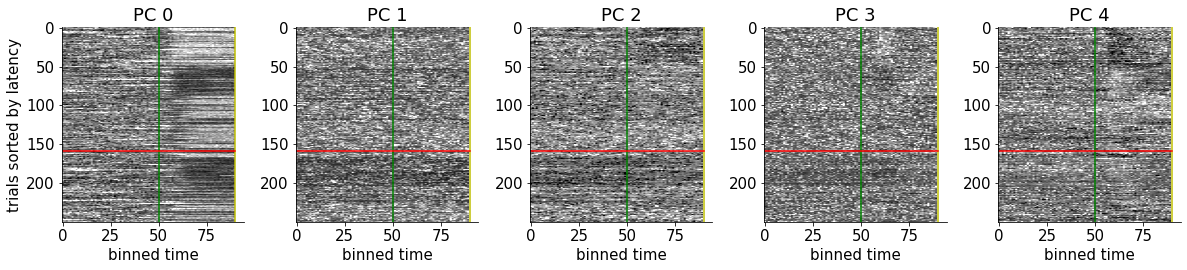

In [38]:

nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1 = zscore(pc_10ms[j])
  plt.imshow(pc1[isort, :], aspect='auto', vmax=2, vmin = -2, cmap = 'gray')
  ax.set(xlabel = 'binned time')
  plt.axvline(50, c='g')
  plt.axvline(90, c='y')
  if j==0:
    ax.set(ylabel = 'trials sorted by latency')  
  plt.title('PC %d'%j)

  plt.plot([0, NT], [nwrong, nwrong], 'r')
plt.savefig(f'/home/droumis/Src/capuchin/figures/PCA_prestimANDstim_5PC_sesh{sesh}.png')
plt.show()

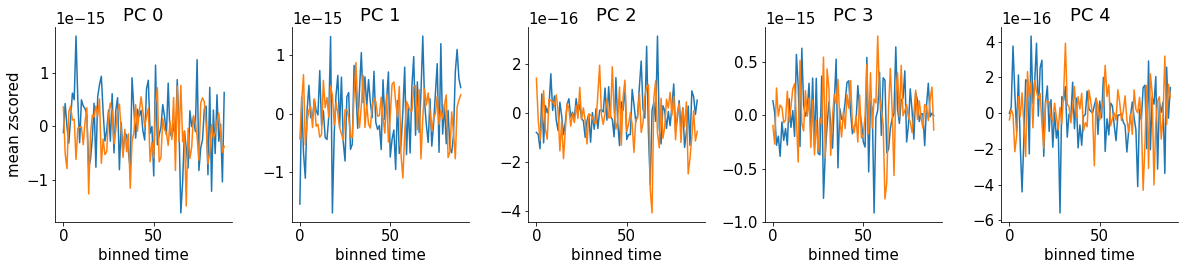

In [39]:
nwrong = np.sum(is_correct)
for j in range(len(pc_10ms)):
  ax = plt.subplot(1,len(pc_10ms)+1,j+1)
  pc1_corr = zscore(pc_10ms[j][is_correct,:])
  pc1_err = zscore(pc_10ms[j][~is_correct,:])
  plt.plot(np.mean(pc1_corr, axis=0))
  plt.plot(np.mean(pc1_err, axis=0))
  ax.set(xlabel = 'binned time')
#   plt.axvline(50, c='g')
#   plt.axvline(90, c='y')
  if j==0:
    ax.set(ylabel = 'mean zscored')  
  plt.title('PC %d'%j)
plt.savefig(f'/home/droumis/Src/capuchin/figures/PCA_prestimANDstim_5PC_mean_sesh{sesh}.png')
plt.show()
#   plt.plot([0, NT], [nwrong, nwrong], 'r')

# GLM

In [40]:
prestim_pc_mean = np.mean(pc_10ms, axis = 2).T

X = prestim_pc_mean
y = is_correct

# First define the model
log_reg = LogisticRegression(penalty="none")

#Then fit it to data
log_reg.fit(X, y)

y_pred = log_reg.predict(X)

## test accuracy

In [41]:
def compute_accuracy(X, y, model):
  """Compute accuracy of classifier predictions.
  
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    model (sklearn estimator): Classifier with trained weights.

  Returns:
    accuracy (float): Proportion of correct predictions.  
  """
  y_pred = model.predict(X)
  accuracy = (y == y_pred).mean()

  return accuracy

In [42]:
train_accuracy = compute_accuracy(X, y, log_reg)
print(f"Accuracy on the training data: {train_accuracy:.2%}")

Accuracy on the training data: 71.20%


## cross validation

In [43]:
accuracies = cross_val_score(LogisticRegression(penalty='none'), X, y, cv=8) # k=8 crossvalidation

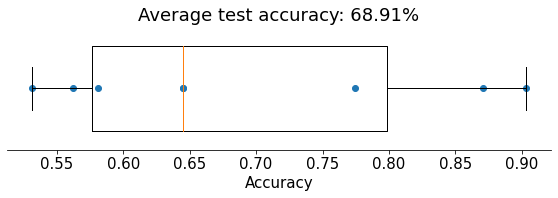

In [44]:
#@title
#@markdown Run to plot out these `k=8` accuracy scores.
f, ax = plt.subplots(figsize=(8, 3))
ax.boxplot(accuracies, vert=False, widths=.7)
ax.scatter(accuracies, np.ones(8))
ax.set(
  xlabel="Accuracy",
  yticks=[],
  title=f"Average test accuracy: {accuracies.mean():.2%}"
)
ax.spines["left"].set_visible(False)
plt.savefig(f'/home/droumis/Src/capuchin/figures/GLM_Accuracy_PCA_prestimANDstim_5PC_sesh{sesh}.png')
plt.show()

# Regularization

In [45]:

def plot_weights(models, sharey=True):
  """Draw a stem plot of weights for each model in models dict."""
  n = len(models)
  f = plt.figure(figsize=(10, 2.5 * n))
  axs = f.subplots(n, sharex=True, sharey=sharey)
  axs = np.atleast_1d(axs)

  for ax, (title, model) in zip(axs, models.items()):

    ax.margins(x=.02)
    stem = ax.stem(model.coef_.squeeze(), use_line_collection=True)
    stem[0].set_marker(".")
    stem[0].set_color(".2")
    stem[1].set_linewidths(.5)
    stem[1].set_color(".2")
    stem[2].set_visible(False)
    ax.axhline(0, color="C3", lw=3)
    ax.set(ylabel="Weight", title=title)
  ax.set(xlabel="Neuron (a.k.a. feature)")
  f.tight_layout()

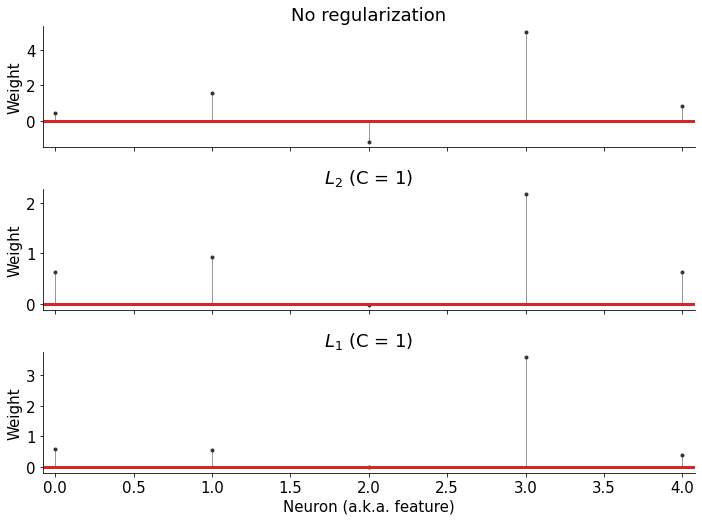

In [46]:
log_reg_l2 = LogisticRegression(penalty="l2", C=1).fit(X, y)
log_reg_l1 = LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=5000)
log_reg_l1.fit(X, y)
# }
# plot_weights(models)
# now show the two models
# models = {
models = {
  "No regularization": log_reg,
  "$L_2$ (C = 1)": log_reg_l2,
  "$L_1$ (C = 1)": log_reg_l1,
}
# plot_weights(models)
plot_weights(models, sharey=False)
plt.savefig(f'/home/droumis/Src/capuchin/figures/GLM_Accuracy_PCA_prestimANDstim_5PC_weights_sesh{sesh}.png')
plt.show()

## L1 Regularization Penalty Hyperparameter

In [47]:
def plot_non_zero_coefs(C_values, non_zero_l1, n_voxels):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, non_zero_l1, marker="o")
  ax.set(
    xticks=C_values,
    xlabel="$C$",
    ylabel="Number of non-zero coefficients",
  )
  ax.axhline(n_voxels, color=".1", linestyle=":")
  ax.annotate("Total\n# Neurons", (C_values[0], n_voxels * .98), va="top")

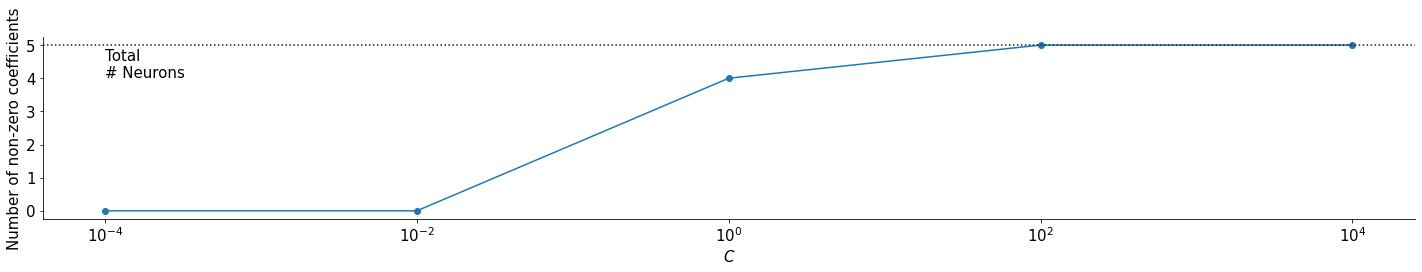

In [48]:
def count_non_zero_coefs(X, y, C_values):
  """Fit models with different L1 penalty values and count non-zero coefficients.

  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): List of hyperparameter values

  Returns:
    non_zero_coefs (list): number of coefficients in each model that are nonzero

  """
  non_zero_coefs = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l1", C=C, solver="saga", max_iter=5000)
    model.fit(X,y)

    # Get the coefs of the fit model
    coefs = model.coef_

    # Count the number of non-zero elements in coefs
    non_zero = np.sum(coefs != 0)
    non_zero_coefs.append(non_zero)

  return non_zero_coefs

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 5)

non_zero_l1 = count_non_zero_coefs(X, y, C_values)

# with plt.xkcd():
plot_non_zero_coefs(C_values, non_zero_l1, n_voxels=X.shape[1])
plt.savefig(f'/home/droumis/Src/capuchin/figures/GLM_Accuracy_PCA_prestimANDstim_5PC_NumNonZeroWeights_sesh{sesh}.png')
plt.show()

In [49]:
def plot_model_selection(C_values, accuracies):
  """Plot the accuracy curve over log-spaced C values."""
  ax = plt.figure().subplots()
  ax.set_xscale("log")
  ax.plot(C_values, accuracies, marker="o")
  best_C = C_values[np.argmax(accuracies)]
  ax.set(
      xticks=C_values,
      xlabel="$C$",
      ylabel="Cross-validated accuracy",
      title=f"Best C: {best_C:1g} ({np.max(accuracies):.2%})",
  )


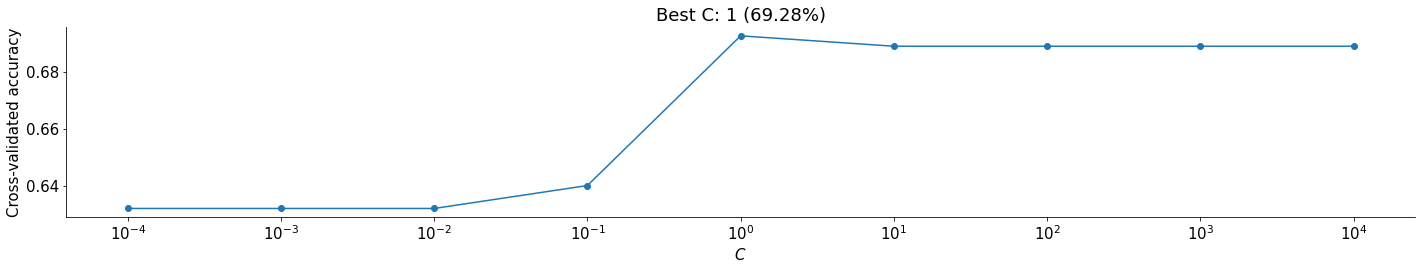

In [50]:
def model_selection(X, y, C_values):
  """Compute CV accuracy for each C value.
  Args:
    X (2D array): Data matrix
    y (1D array): Label vector
    C_values (1D array): Array of hyperparameter values.
  Returns:
    accuracies (1D array): CV accuracy with each value of C.
  """
  accuracies = []
  for C in C_values:

    # Initialize and fit the model
    # (Hint, you may need to set max_iter)
    model = LogisticRegression(penalty="l2", C=C, max_iter=5000)

    # Get the accuracy for each test split
    accs = cross_val_score(model, X, y, cv=8)

    # Store the average test accuracy for this value of C
    accuracies.append(accs.mean())

  return accuracies

# Use log-spaced values for C
C_values = np.logspace(-4, 4, 9)

accuracies = model_selection(X, y, C_values)
# with plt.xkcd():
plot_model_selection(C_values, accuracies)
plt.savefig(f'/home/droumis/Src/capuchin/figures/GLM_Accuracy_PCA_prestimANDstim_5PC_crossValAccuracy_sesh{sesh}.png')
plt.show()